# RUL estimation using LSTM

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from tensorflow import keras

import absl.logging
import os

In [3]:
from keras import backend as K

In [4]:
train = pd.read_csv('D:\Preet\Internship Raj Vijtech\Aircraft data & analysis\CSV data files\Train_data_csv.csv')
test = pd.read_csv('D:\Preet\Internship Raj Vijtech\Aircraft data & analysis\CSV data files\Test_data_csv.csv')
truth = pd.read_csv('D:\Preet\Internship Raj Vijtech\Aircraft data & analysis\CSV data files\RUL_data_csv.csv')

# Data Preprocessing

In [15]:
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)

rul = pd.DataFrame(train.groupby('Unit No.')['Time in Cycles'].max()).reset_index()
rul.columns = ['Unit No.', 'max']
train = train.merge(rul, on=['Unit No.'], how='left')
train = train.drop('Label',axis = 1)
train['RUL'] = train['max'] - train['Time in Cycles']
train = train.drop('max', axis = 1)

In [16]:
# generate label columns for training data
# Label 1 for Binary classification & Label 2 for 3 class classification

w1 = 30
w0 = 15
train['Label1'] = np.where(train['RUL'] <= w1, 1,0)
train['Label2'] = train['Label1']
train.loc[train['RUL'] <= w0, 'Label2'] = 2

# Scale data to values b/w 0 & 1 with Minmax Normalization

train['cycle_norm'] = train['Time in Cycles']
cols_normalize = train.columns.difference(['Unit No.','Time in Cycles','RUL','Label1','Label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train.index)
join_df = train[train.columns.difference(cols_normalize)].join(norm_train_df)
train = join_df.reindex(columns = train.columns)

In [17]:
# Scale the test data like train data

test['cycle_norm'] = test['Time in Cycles']
norm_test = pd.DataFrame(min_max_scaler.transform(test[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test.index)
test_join_df = test[test.columns.difference(cols_normalize)].join(norm_test)
test = test_join_df.reindex(columns = test.columns)
test = test.reset_index(drop=True)

# Use real RUL data(truth dataframe) to generate labels for test data
# generate a column of max cycles for test data

truth.drop(truth.columns[[0]], axis=1, inplace=True)
rul = pd.DataFrame(test.groupby('Unit No.')['Time in Cycles'].max()).reset_index()
rul.columns = ['Unit No.', 'max']
truth.columns = ['more']
truth['Unit No.'] = truth.index + 1
truth['max'] = rul['max'] + truth['more']
truth = truth.drop('more', axis=1)

# generate RUL column for test data

test = test.merge(truth, on=['Unit No.'], how='left')
test['RUL'] = test['max'] - test['Time in Cycles']
test = test.drop('max', axis=1)

# generate label1 & Label2 for test data

test['Label1'] = np.where(test['RUL'] <= w1, 1, 0 )
test['Label2'] = test['Label1']
test.loc[test['RUL'] <= w0, 'Label2'] = 2

In [18]:
sequence_length = 50

# define a function to reshape data into (samples, time steps, features) 

def gen_sequence(id_, seq_length, seq_cols):
    
    #make a matrix which contains all the rows of single id
    data_matrix = id_[seq_cols].values
    num_elements = data_matrix.shape[0]
    
    # Iterate over two lists in parallel
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,142),(50,192)
    
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

# Make Feature Column

sensor_cols = ['S' + str(i) for i in range(1,22)]
sequence_cols = ['Op.Setting 1', 'Op.Setting 2', 'Op.Setting 3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# sequence generator
seq_gen = (list(gen_sequence(train[train['Unit No.']==id], sequence_length, sequence_cols)) 
           for id in train['Unit No.'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

(15631, 50, 25)


In [19]:
# function to generate labels same as sequence generator
def gen_labels(id_, seq_length, label):
    
    data_matrix = id_[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

# generate labels

label_gen = [gen_labels(train[train['Unit No.']==id], sequence_length, ['RUL']) 
             for id in train['Unit No.'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
print(label_array.shape)

(15631, 1)


In [20]:
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [21]:
# build the model which is very similar to the previous one

nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model_path1 = 'model1.h5'
model = Sequential()
model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 100)           50400     
                                                                 
 dropout_2 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 80,651
Trainable params: 80,651
Non-trai

In [22]:
# fit the model

history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(filepath = model_path1,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
# list all data in history
print(history.history.keys())

Epoch 1/100
75/75 - 26s - loss: 8832.8877 - mae: 75.2876 - r2_keras: -1.7248e+00 - val_loss: 8249.6494 - val_mae: 72.4057 - val_r2_keras: -2.4708e+00 - 26s/epoch - 349ms/step
Epoch 2/100
75/75 - 18s - loss: 8159.1973 - mae: 71.3761 - r2_keras: -1.5145e+00 - val_loss: 7723.1411 - val_mae: 69.3461 - val_r2_keras: -2.2220e+00 - 18s/epoch - 234ms/step
Epoch 3/100
75/75 - 18s - loss: 7643.7676 - mae: 68.4152 - r2_keras: -1.3623e+00 - val_loss: 7223.9644 - val_mae: 66.4617 - val_r2_keras: -1.9881e+00 - 18s/epoch - 243ms/step
Epoch 4/100
75/75 - 19s - loss: 7153.0068 - mae: 65.6059 - r2_keras: -1.2044e+00 - val_loss: 6757.4478 - val_mae: 63.7830 - val_r2_keras: -1.7714e+00 - 19s/epoch - 259ms/step
Epoch 5/100
75/75 - 19s - loss: 6702.7856 - mae: 63.0448 - r2_keras: -1.0614e+00 - val_loss: 6319.9375 - val_mae: 61.2903 - val_r2_keras: -1.5702e+00 - 19s/epoch - 247ms/step
Epoch 6/100
75/75 - 20s - loss: 6274.0278 - mae: 60.6484 - r2_keras: -9.3348e-01 - val_loss: 5907.3652 - val_mae: 58.9603 - v

dict_keys(['loss', 'mae', 'r2_keras', 'val_loss', 'val_mae', 'val_r2_keras'])


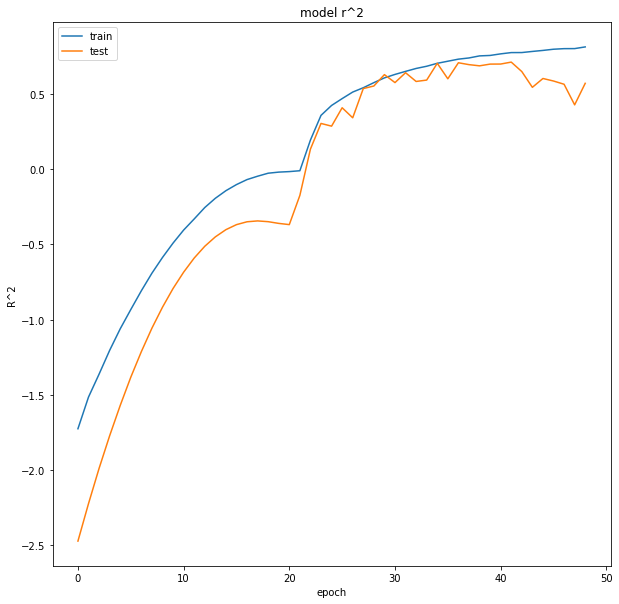

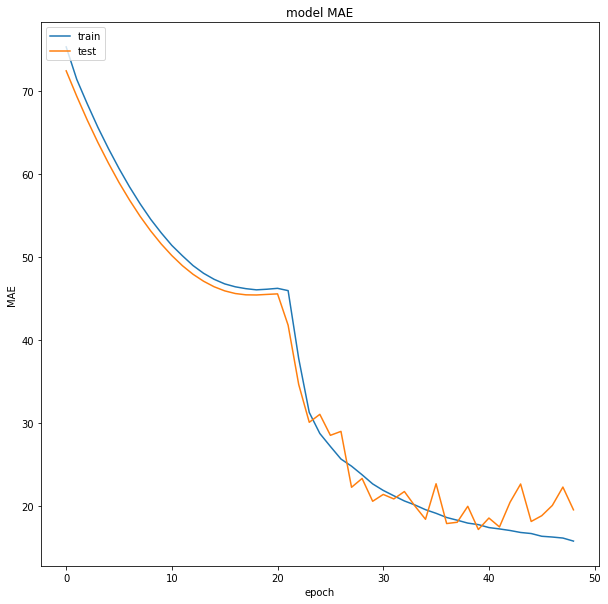

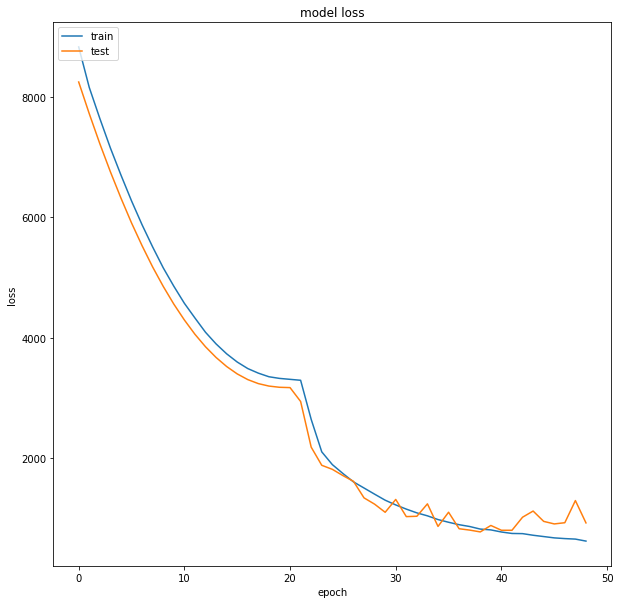

In [23]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_r2.png")

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_mae.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_regression_loss.png")

In [24]:
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array


79/79 [==============================] - 12s 155ms/step - loss: 557.6398 - mae: 15.3000 - r2_keras: 0.7934

MAE: 15.29997444152832

R^2: 0.7934222221374512
79/79 [==============================] - 15s 163ms/step


In [25]:
# We pick the last sequence for each id in the test data
seq_array_test_last = [test[test['Unit No.']==id][sequence_cols].values[-sequence_length:] 
                       for id in test['Unit No.'].unique() if len(test[test['Unit No.']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

y_mask = [len(test[test['Unit No.']==id]) >= sequence_length for id in test['Unit No.'].unique()]
label_array_test_last = test.groupby('Unit No.')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

In [26]:
if os.path.isfile(model_path1):
    estimator = load_model(model_path1,custom_objects={'r2_keras': r2_keras})


In [27]:
scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('\nMAE: {}'.format(scores_test[1]))
print('\nR^2: {}'.format(scores_test[2]))

y_pred_test = estimator.predict(seq_array_test_last)
y_true_test = label_array_test_last

3/3 - 2s - loss: 275.5794 - mae: 12.0687 - r2_keras: 0.8286 - 2s/epoch - 813ms/step

MAE: 12.068682670593262

R^2: 0.8285741806030273


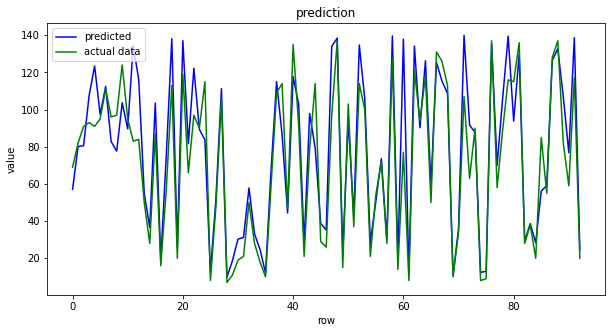

In [28]:
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("model_regression_verify.png")

In [33]:
rul_predict = pd.DataFrame(y_pred_test)

In [35]:
rul_predict['True RUL'] = y_true_test

In [38]:
rul_predict.to_excel('LSTM_output.xlsx')

In [1]:
test

NameError: name 'test' is not defined